# LOAD WHAT WE NEED FOR THIS

In [94]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from utils import *

import snowballstemmer
import nltk
# from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin

## Load data

In [95]:
PATH = os.getcwd()

In [96]:
raw_df = pd.read_csv(f'{PATH}/data/Airline-Sentiment-2-w-AA.csv', encoding='ISO-8859-1')

In [97]:
raw_df.shape

(14640, 20)

## Preprocess data

#### Sample print data

In [98]:
raw_df.sample(5)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
10806,681462100,False,finalized,3,2/25/15 3:39,negative,1.000,Late Flight,1.0000,US Airways,NaN,DrJamesPrescott,NaN,0,"@USAirways Batting 1.000! Four flights in a month, all four delayed!",NaN,2/20/15 11:55,5.688620e+17,tennessee,NaN
8939,681459978,False,finalized,3,2/25/15 8:09,positive,0.701,NaN,0.0000,Delta,NaN,leighericam,NaN,0,@JetBlue well lucky I only fly JB..I guess I would be even more squished on any other airline _Ù÷_,NaN,2/17/15 9:10,5.677330e+17,NYC | NOLA,NaN
2438,681451724,False,finalized,3,2/25/15 7:55,neutral,1.000,NaN,NaN,United,NaN,jimccooper,NaN,0,@united I was able to get a seat on earlier flight sfo to ind. Can you add me to 6pm ord to IND?,NaN,2/21/15 10:52,5.692080e+17,NaN,Eastern Time (US & Canada)
2312,681451549,False,finalized,3,2/25/15 7:37,negative,1.000,Cancelled Flight,0.6513,United,NaN,scottychadwick,NaN,0,@united friends been sitting in Houston since 7am flight Cancelled Flighted.Still don't have any answers. #BadCustomerService #$10voucherwhatajoke,NaN,2/21/15 14:25,5.692620e+17,NaN,Eastern Time (US & Canada)
5661,681455662,False,finalized,3,2/25/15 1:30,negative,1.000,Customer Service Issue,0.6310,Southwest,NaN,Megs701,NaN,0,@SouthwestAir you will extend if I call the day it expires.why can't it just be extended now?#mightmismybrosgraduation,NaN,2/20/15 9:47,5.688290e+17,NaN,NaN


#### Null values

In [99]:
raw_df.isnull().sum()

_unit_id                        0    
_golden                         0    
_unit_state                     0    
_trusted_judgments              0    
_last_judgment_at               56   
airline_sentiment               0    
airline_sentiment:confidence    0    
negativereason                  5462 
negativereason:confidence       4118 
airline                         0    
airline_sentiment_gold          14600
name                            0    
negativereason_gold             14608
retweet_count                   0    
text                            0    
tweet_coord                     13621
tweet_created                   0    
tweet_id                        0    
tweet_location                  4733 
user_timezone                   4820 
dtype: int64

#### Target class distribution

In [100]:
raw_df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [101]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
sns.set_style(style='whitegrid')

In [102]:
df = raw_df[['text', 'airline_sentiment']].copy()

In [103]:
df.shape

(14640, 2)

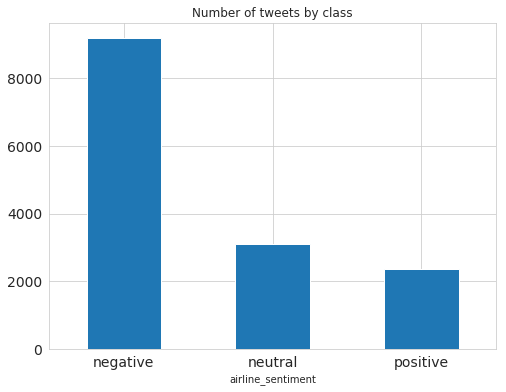

In [104]:
df.groupby(['airline_sentiment']).count().plot(kind='bar', figsize=(8, 6), rot=0, legend=False, title='Number of tweets by class');

In [105]:
pd.set_option('display.max_colwidth', -1)

In [106]:
df.sample(5)

,text,airline_sentiment
10269,@USAirways 2 hours on hold. Still no answer. Horrible.,negative
5110,@SouthwestAir On hold with airline 45 min and counting. Service is terrible!,negative
14617,@AmericanAir DMing you now! Big thanks.,positive
11218,@USAirways @HirasmusBidragi will try.. Now stuck on tarmac waiting on gate. :( may miss 9:25 connection #883),negative
2054,@united nice. I wonder how you pick who to respond to? Maybe only happy customers are easier. I wonder how many of those you have left.,negative


### remove some mention and non alphabetic words

In [107]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [108]:
df['tidy_text'] = np.vectorize(remove_pattern)(df['text'], "@[\w]*")
df['tidy_text'] = df['tidy_text'].str.replace("[^a-zA-Z#]", " ")
df['tidy_text'] = df['tidy_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# ct = TextCleaner()
# df['tidy_text'] = ct.transform(df['text'])
df['string_text'] = df['tidy_text']
df.head()

,text,airline_sentiment,tidy_text,string_text
0,@VirginAmerica What @dhepburn said.,neutral,What said,What said
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive,plus added commercials experience tacky,plus added commercials experience tacky
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral,didn today Must mean need take another trip,didn today Must mean need take another trip
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative,really aggressive blast obnoxious entertainment your guests faces they have little recourse,really aggressive blast obnoxious entertainment your guests faces they have little recourse
4,@VirginAmerica and it's a really big bad thing about it,negative,really thing about,really thing about


### Tokenized

In [109]:
tokenized_tweet = df['tidy_text'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [What, said]                                                                                            
1    [plus, added, commercials, experience, tacky]                                                           
2    [didn, today, Must, mean, need, take, another, trip]                                                    
3    [really, aggressive, blast, obnoxious, entertainment, your, guests, faces, they, have, little, recourse]
4    [really, thing, about]                                                                                  
Name: tidy_text, dtype: object

In [110]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()


0    [what, said]                                                                              
1    [plu, ad, commerci, experi, tacki]                                                        
2    [didn, today, must, mean, need, take, anoth, trip]                                        
3    [realli, aggress, blast, obnoxi, entertain, your, guest, face, they, have, littl, recours]
4    [realli, thing, about]                                                                    
Name: tidy_text, dtype: object

In [111]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

df['tidy_text'] = tokenized_tweet
df.head()
# df.shape

,text,airline_sentiment,tidy_text,string_text
0,@VirginAmerica What @dhepburn said.,neutral,what said,What said
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive,plu ad commerci experi tacki,plus added commercials experience tacky
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral,didn today must mean need take anoth trip,didn today Must mean need take another trip
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative,realli aggress blast obnoxi entertain your guest face they have littl recours,really aggressive blast obnoxious entertainment your guests faces they have little recourse
4,@VirginAmerica and it's a really big bad thing about it,negative,realli thing about,really thing about


### WORDCLOUD

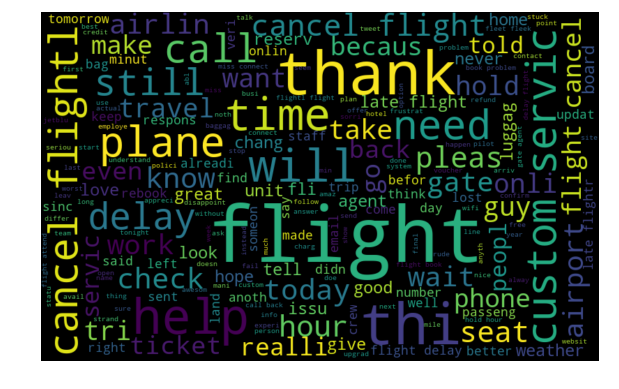

In [112]:
all_words = ' '.join([text for text in df['tidy_text']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


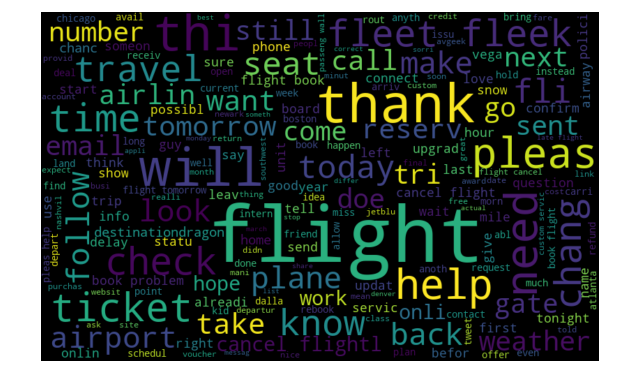

In [113]:
normal_words =' '.join([text for text in df['tidy_text'][df['airline_sentiment'] == 'neutral']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


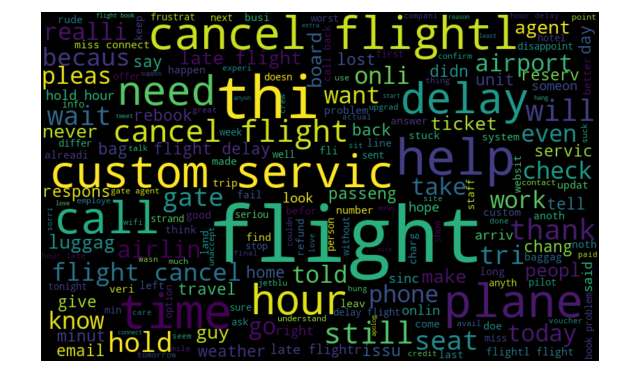

In [114]:
negative_words = ' '.join([text for text in df['tidy_text'][df['airline_sentiment'] == 'negative']])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


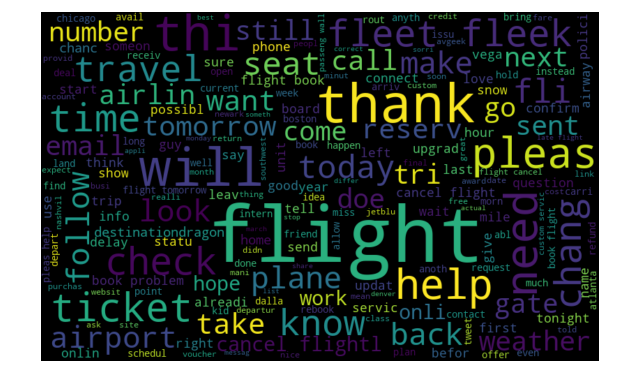

In [115]:
positive_words =' '.join([text for text in df['tidy_text'][df['airline_sentiment'] == 'positive']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


### Extract Hashtag

In [116]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags



In [117]:
# extracting hashtags from non normal tweets
HT_regular = hashtag_extract(df['tidy_text'][df['airline_sentiment'] == 'neutral'])

# extracting hashtags from negative tweets
HT_negative = hashtag_extract(df['tidy_text'][df['airline_sentiment'] == 'negative'])

# extracting hashtags from positive tweets
HT_positive = hashtag_extract(df['tidy_text'][df['airline_sentiment'] == 'positive'])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])
HT_positive = sum(HT_positive,[])




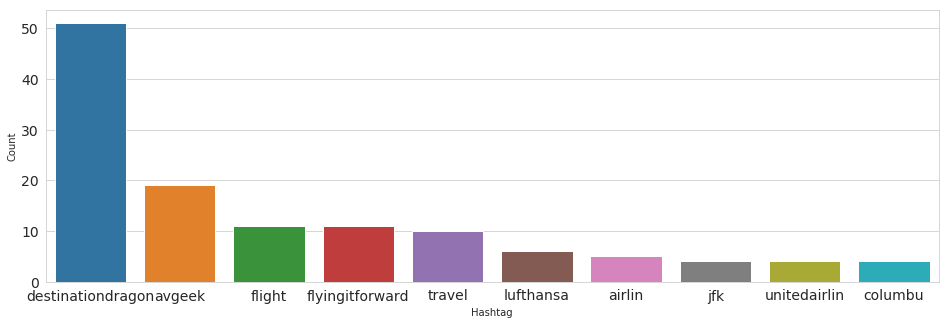

In [118]:
HT_regular_plot = nltk.FreqDist(HT_regular)
HT_regular_df = pd.DataFrame({'Hashtag': list(HT_regular_plot.keys()),
                  'Count': list(HT_regular_plot.values())})
# selecting top 10 most frequent hashtags     
HT_regular_df = HT_regular_df.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=HT_regular_df, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()


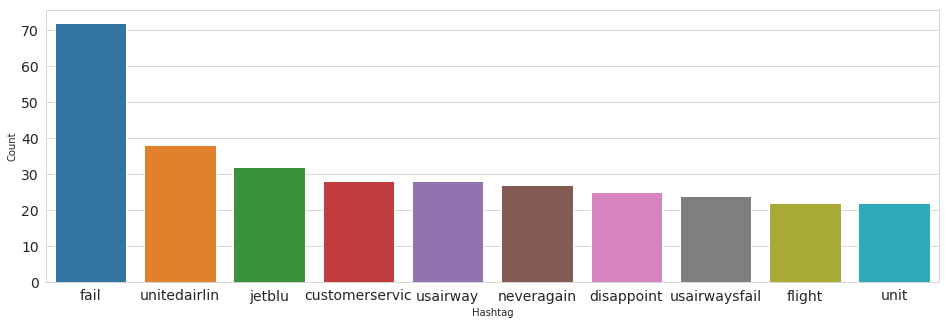

In [119]:
HT_negative_plot = nltk.FreqDist(HT_negative)
HT_negative_df = pd.DataFrame({'Hashtag': list(HT_negative_plot.keys()),
                  'Count': list(HT_negative_plot.values())})
# selecting top 10 most frequent hashtags     
HT_negative_df = HT_negative_df.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=HT_negative_df, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()


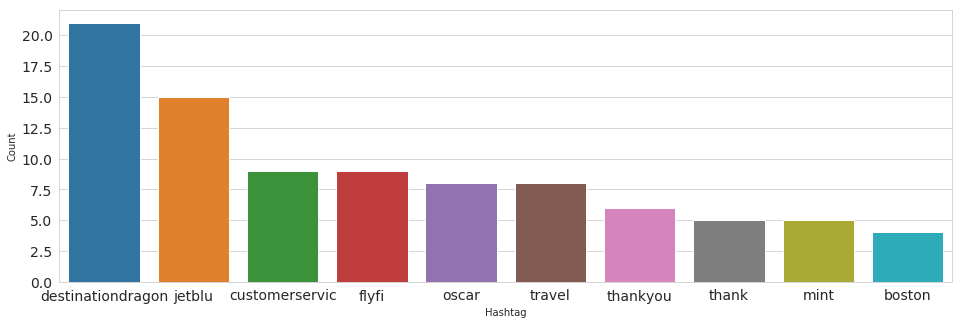

In [120]:
HT_positive_plot = nltk.FreqDist(HT_positive)
HT_positive_df = pd.DataFrame({'Hashtag': list(HT_positive_plot.keys()),
                  'Count': list(HT_positive_plot.values())})
# selecting top 10 most frequent hashtags     
HT_positive_df = HT_positive_df.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=HT_positive_df, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()


### Encode categorical label class into numerical

In [121]:
le = LabelEncoder()
df['target'] = le.fit_transform(df['airline_sentiment'])

### Text cleaning

In [122]:
ct = TextCleaner()
df['clean_text'] = ct.transform(df['text'])
df.head()
df['clean_text'].values.itemsize

8

### Tokenizer

In [123]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
stemmer = snowballstemmer.EnglishStemmer()

def tokenize(s): 
    tokens = re_tok.sub(r' \1 ', s).split()
    return stemmer.stemWords(tokens)

### Train, test splitting

In [124]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'].values, df['target'].values, test_size=0.25, random_state=0)


### Tf-idf

In [125]:
vect = TfidfVectorizer(strip_accents='unicode', tokenizer=tokenize, ngram_range=(1, 2), max_df=0.75, min_df=3, sublinear_tf=True)

In [126]:
tfidf_train = vect.fit_transform(X_train)
# print("tfidf_train")
# print(tfidf_train.shape)
tfidf_test = vect.transform(X_test)
# print("tfidf_test")
# print(tfidf_test)

## Naive Bayes

In [127]:
def naive_bayes(x, y):
    r = []; b = []
    labels = np.unique(y)

    for l in labels:
        other_l = labels[labels != l]
        p = x[y == l].sum(0) + 1
        q = x[(y == other_l[0]) | (y == other_l[1])].sum(0) + 1
        r.append(np.log((p/p.sum())/(q/q.sum())))
        b.append(np.log(len(p)/len(q)))
    
    return r, b

In [128]:
r, b = naive_bayes(tfidf_train, y_train)

pre_preds = []
for j in range(len(r)):
    pre_preds.append(np.asarray(tfidf_test @ r[j].T + b[j]).reshape(-1))
arr = np.array(pre_preds)

In [129]:
metrics.accuracy_score(y_test, np.argmax(arr.T, 1))

0.7959016393442623

In [130]:
print(metrics.classification_report(y_test, np.argmax(arr.T, 1), target_names=le.classes_))

              precision    recall  f1-score   support

    negative       0.82      0.94      0.87      2327
     neutral       0.72      0.49      0.59       772
    positive       0.77      0.63      0.69       561

   micro avg       0.80      0.80      0.80      3660
   macro avg       0.77      0.69      0.72      3660
weighted avg       0.79      0.80      0.78      3660



## Logistic Regression

Cross validation with 5 folds

In [131]:
scores = cross_val_score(LogisticRegression(C=4, dual=True), tfidf_train, y_train, cv=5)

/home/erick/.virtualenvs/py3dm/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/erick/.virtualenvs/py3dm/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [132]:
scores

array([0.80709736, 0.79745107, 0.80546697, 0.80091116, 0.81867882])

In [133]:
np.mean(scores), np.std(scores)

(0.8059210756972217, 0.007227586380912802)

Train over complete training set

In [134]:
m = LogisticRegression(C=4, dual=True)
m.fit(tfidf_train, y_train)

LogisticRegression(C=4, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Evaluating on test set

In [135]:
preds = m.predict(tfidf_test)
(preds==y_test).mean()

0.8087431693989071

In [136]:
print(metrics.classification_report(y_test, preds, target_names=le.classes_))

              precision    recall  f1-score   support

    negative       0.83      0.94      0.88      2327
     neutral       0.71      0.54      0.62       772
    positive       0.81      0.63      0.71       561

   micro avg       0.81      0.81      0.81      3660
   macro avg       0.78      0.70      0.73      3660
weighted avg       0.80      0.81      0.80      3660



#### Tokens importance

In [137]:
def get_tokens_coefs(vocab, coefs, n):
    coef_df = pd.DataFrame({'vocab': vocab, 'coef':coefs.reshape(-1)})
    return coef_df.sort_values('coef', ascending=False).reset_index(drop=True)[:n]

In [138]:
def plot_tokens_coefs(df, ax, label):
    df.sort_values('coef').plot.barh(legend=False, ax=ax)
    ax.set_yticklabels(df['vocab'].values.tolist()[::-1])
    ax.set_title(label);

In [139]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
sns.set_style(style='white')

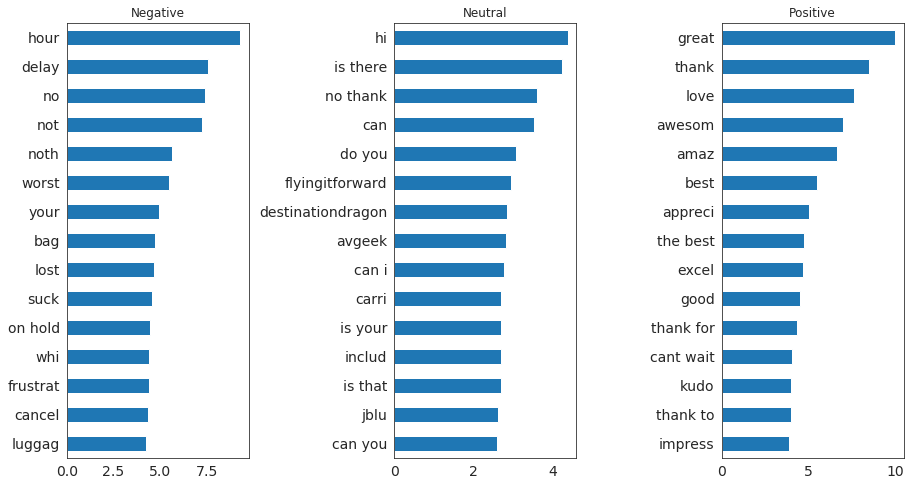

In [50]:
vocab = vect.get_feature_names()
n_coefs = 15

fig, axs = plt.subplots(1, 3, figsize=(15, 8))
fig.subplots_adjust(wspace=0.8)

for i, l in enumerate(['Negative', 'Neutral', 'Positive']):
    coef_df = get_tokens_coefs(vocab, m.coef_[i], n_coefs)
    plot_tokens_coefs(coef_df, axs[i], l)